# Retrieval 1: Static parameters 

:::{admonition} About this retrieval example
This example shows how to use the [rt1 python package](https://github.com/raphaelquast/rt1_model) together with [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) to setup a retrieval procedure to obtain: 

- a set of constant RT1 parameters from an incidence-angle dependent $\sigma^0$ dataset.
:::

In [1]:
%matplotlib widget
from rt1_model import RT1, surface, volume, set_loglevel
from scipy.optimize import least_squares
import numpy as np

set_loglevel("info")

## Specify simulation and fit parameters
### Set parameter values that are used to simulate the data

In [2]:
dB = True    # calculate values in decibel
sig0 = True  # calculate sigma0 values rather than intensities

noise_sigma = 0.5 if dB is True else 1e-3               # Noise-level (sigma of gaussian noise)
inc = np.random.normal(45, 10, (1000,)).clip(20, 70)    # Incidence angles
sim_params = dict(tau=0.3, omega=0.4, N=0.1, t_s=0.4)   # Simulation parameter values

### Set start values and boundaries for the fit

In [3]:
start_vals = dict(tau=0.1, omega=0.2, N=0.3, t_s=0.1)
bnd_vals = dict(tau=(0.01, 0.5), omega=(0.01, 0.5), N=(0.01, 0.5), t_s=(0.01, 0.5))

## Setup RT1 and create a simulated dataset

In [4]:
V = volume.Rayleigh()
SRF = surface.HG_nadirnorm(t="t_s", ncoefs=10)

R = RT1(V=V, SRF=SRF, int_Q=True, dB=dB, sig0=sig0)
R.set_monostatic(p_0=0)
R.NormBRDF = "N"  # Use a synonym for NormBRDF parameter

R.set_geometry(t_0=np.deg2rad(inc))
R.update_params(**sim_params)

tot, surf, vol, inter = R.calc()
tot += np.random.normal(0, noise_sigma, tot.size)  # Add some random noise

16:07:30.940 INFO: Evaluating coefficients for interaction-term...
16:07:31.052 INFO: Coefficients extracted, it took 0.01251 sec.


## Setup scipy optimize to fit RT1 model to the data

In [5]:
param_names = list(sim_params)

def parse_params(x):
    """Map 1D parameter array to dict {parameter_name: value(s)}."""
    return dict(zip(param_names, x))

def fun(x):
    """Calculate residuals."""
    R.update_params(**parse_params(x))
    res = (R.calc()[0] - tot).ravel()
    return res

def jac(x):
    """Calculate jacobian."""
    R.update_params(**parse_params(x))
    jac = R.jacobian(param_list=list(param_names), format="scipy_least_squares")
    return jac


# Unpack start-values and boundaries as required by scipy optimize
x0 = [start_vals[key] for key in param_names]
bounds = list(zip(*[bnd_vals[key] for key in param_names]))

res = least_squares(
    fun=fun,
    x0=x0,
    bounds=bounds,
    jac=jac,
    ftol=1e-8,
    gtol=1e-8,
    xtol=1e-3,
    verbose=2,
)

found_params = dict(zip(param_names, res.x))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.5875e+03                                    1.45e+04    
       1              2         1.4840e+03      6.10e+03       1.46e-01       4.45e+03    
       2              3         5.0818e+02      9.76e+02       9.46e-02       1.58e+03    
       3              4         2.3556e+02      2.73e+02       1.02e-01       7.17e+02    
       4              5         1.4247e+02      9.31e+01       6.18e-02       2.85e+02    
       5              6         1.2572e+02      1.67e+01       5.37e-02       1.18e+02    
       6              7         1.2544e+02      2.84e-01       7.18e-02       3.32e+02    
       7              8         1.2118e+02      4.26e+00       1.08e-02       7.65e+00    
       8              9         1.2071e+02      4.66e-01       1.47e-02       2.17e+01    
       9             10         1.2013e+02      5.84e-01       2.69e-02       4.69e+01    

In [12]:
from IPython.display import HTML, display
s = ["<table>",
     "<caption>Retrieved Parameters</caption>",
     "<tr><th>Parameter</th><th>Target value</th><th>Found value</th><th>Difference</th></tr>",
     *(f"<tr><td>{key if isinstance(val, (int, float, np.number)) else key + ' <b>(mean)</b>'} </td>"
       f"<td> {np.mean(sim_params[key]):.3f} </td><td> {np.mean(val):.3f}</td>"
       f"<td>{np.mean(val - sim_params[key]): .3f}</td></tr>" 
       for key, val in found_params.items()),
     "</table>"]
display(HTML("\n".join(s)))

Parameter,Target value,Found value,Difference
tau,0.300,0.421,0.121
omega,0.400,0.349,-0.051
N,0.100,0.137,0.037
t_s,0.400,0.484,0.084


## Initialize analyzer widget and overlay results

16:07:45.784 INFO: Evaluating coefficients for interaction-term...
16:07:45.856 INFO: Coefficients extracted, it took 0.01672 sec.


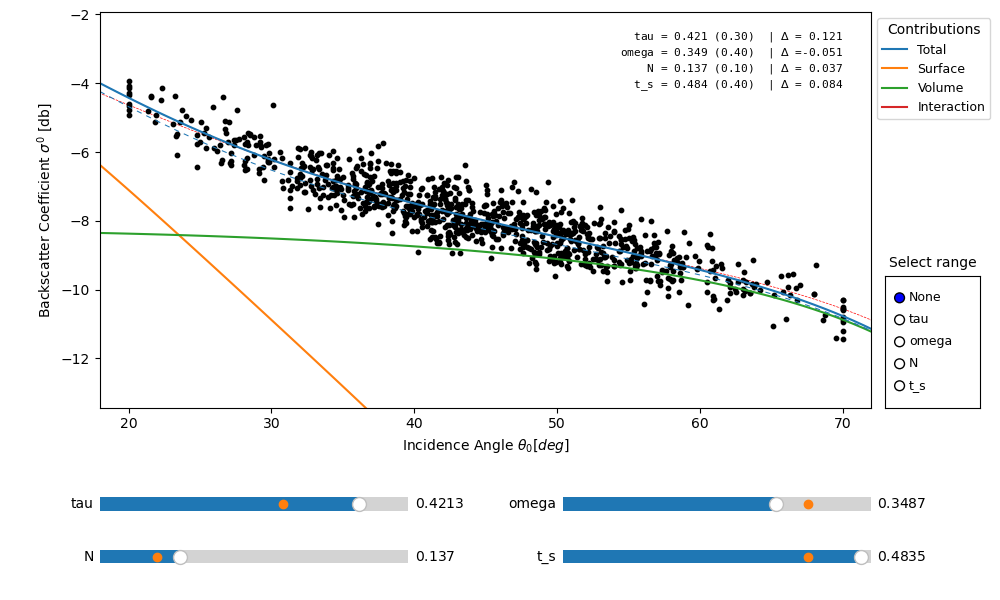

In [7]:
analyze_params = {key: (0.01, 0.5, found_params[key]) for key in param_names}
ana = R.analyze(**analyze_params)

# Plot fit-data on top
ana.ax.scatter(inc, tot, s=10, c="k")

ana.ax.plot(
    np.rad2deg(R.t_0).squeeze(),
    R.calc(**sim_params)[0].squeeze(),
    c="r",
    ls="--",
    lw=0.5,
    zorder=0,
)
ana.ax.plot(
    np.rad2deg(R.t_0).squeeze(),
    R.calc(**found_params)[0].squeeze(),
    c="C0",
    ls="--",
    lw=0.5,
    zorder=0,
)

# Set limits to fit-data range
ana.ax.set_xlim(inc.min() - 2, inc.max() + 2)
ana.ax.set_ylim(tot.min() - 2, tot.max() + 2)

# Indicate fit-results in slider-axes
for key, s in ana.sliders.items():
    if key in sim_params:
        s.ax.plot(sim_params[key], np.mean(s.ax.get_ylim()), marker="o")

# Add text
t = ana.f.text(
    0.6,
    0.95,
    "\n".join(
        [
            f"{key:>8} = {found:.3f} ({sim_params[key]:.2f})  "
            rf"| $\Delta$ ={found - sim_params[key]: .3f}"
            for (key, found) in found_params.items()
        ]
    ),
    va="top",
    fontdict=dict(family="monospace", size=8),
)